In [1]:
import math, copy, sys, logging, json, time, random, os, string, pickle, re

import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

from modules.TransformerComponents import Transformer
from modules.Vocabulary import Vocab
from modules.MetaLearnNeuralMemory import MNMp
from modules.LoadTrainSave import save_model, load_model

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(0) 
random.seed(0)
torch.manual_seed(0)

print('torch.version', torch.__version__)
print('torch.cuda.is_available()', torch.cuda.is_available())
print('torch.cuda.device_count()', torch.cuda.device_count())

torch.version 1.7.1
torch.cuda.is_available() False
torch.cuda.device_count() 0


# Minimal Working Example

This notebook serves as a minimal working example of Meta-Learned Nerual Memory Chatbot (MNMC). The Teacher teaches a simple conversational lesson, "when I tell you a name, remember my name, when I ask you want my name is, tell me what my name is, if I tell you I have a different name, memorize that new name, when I ask you what my name is, tell me the most recent name I told you" 

# Why is this special?

Seems like a somewhat mundane task, however, the mechanism by which it is accomplished is what is profound. The "name" is not stored in any kind of traditional database or data structure, but rather has been stored in the distributed, aka, shared, weights of a neural network. No new row or element is added to a table or array when the name is remembered, instead the values of a finite set of weights is adjusted. 

# Explaination

Here we show an end to end, albeit minimal, example, the subsequent notebooks will explain Metalearned Nerual memory and how we have combined this with the Transformer

In [2]:
class Teacher(): 
    
    def __init__(self, vocab):
        
        self.vocab = vocab

        self.vocab.string2embedding("my name is, hi. what is my name? its")
        
        self.name_list = [
                          'vicki', 'carson', 'melissa', 'salvador', 
                          'force', 'sky', 'zen', 'adam'
                         ]

    def random_name(self,):
        """ Generate a random string of fixed length """
        return random.choice(self.name_list)
    
    def repeat(self, batch_size):
        
        self.mynameis = self.vocab.string2tensor("my name is")
        self.hi = self.vocab.string2tensor("hi")
        self.whatmyname = self.vocab.string2tensor("what is my name?")
        self.its = self.vocab.string2tensor("its")

        self.mynameis = self.mynameis.repeat(batch_size,1)
        self.hi = self.hi.repeat(batch_size,1)
        self.whatmyname = self.whatmyname.repeat(batch_size,1)
        self.its = self.its.repeat(batch_size,1)
    
    def get_batch(self, batch_size):
        
        self.repeat(batch_size)
        
        newnames = ""
        for n in range(batch_size):
            newnames += " " + self.random_name()
            
        self.vocab.string2embedding(newnames)
        
        self.names = self.vocab.string2tensor(newnames).T

        self.intro = torch.cat((self.mynameis, self.names),dim=1)
        self.introtarget = torch.cat((self.hi, self.names),dim=1)
        self.yournameis = torch.cat((self.its, self.names),dim=1)
        
        return self.intro, self.introtarget, self.whatmyname, self.yournameis

Demonstration of the training data outputted from the teacher

In [3]:
vocab = Vocab(emb_dim=32)
teacher = Teacher(vocab)

print(vocab.word2index)

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'my': 4, 'name': 5, 'is': 6, ',': 7, 'hi': 8, '.': 9, 'what': 10, '?': 11, 'its': 12}


In [4]:
batch_size = 4

intro, introtarget, whatmyname, yournameis = teacher.get_batch(batch_size)

print(vocab.word2index)

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'my': 4, 'name': 5, 'is': 6, ',': 7, 'hi': 8, '.': 9, 'what': 10, '?': 11, 'its': 12, 'zen': 13, 'vicki': 14, 'force': 15}


In [5]:
intro # my name is <new token>

tensor([[ 4,  5,  6, 13],
        [ 4,  5,  6, 13],
        [ 4,  5,  6, 14],
        [ 4,  5,  6, 15]])

In [6]:
introtarget # hi <new token>

tensor([[ 8, 13],
        [ 8, 13],
        [ 8, 14],
        [ 8, 15]])

In [7]:
whatmyname # what is my name ?

tensor([[10,  6,  4,  5, 11],
        [10,  6,  4,  5, 11],
        [10,  6,  4,  5, 11],
        [10,  6,  4,  5, 11]])

In [8]:
yournameis # its <new token>

tensor([[12, 13],
        [12, 13],
        [12, 14],
        [12, 15]])

# Minimal Chatbot (Bot)

With built in memory unit, training unit (teacher forcing) and chatting unit (string2string)

In [3]:
class Bot(nn.Module):
    
    def __init__(self, emb_dim, n_layers, heads, dropout, vocab):
        
        super().__init__()
        
        self.emb_dim = emb_dim
        
        self.vocab = vocab
        self.sos_tok = torch.LongTensor([[self.vocab.word2index["<SOS>"]]]) 
        self.eos_tok = torch.LongTensor([[self.vocab.word2index["<EOS>"]]]) 
        
        self.encodeInput = Transformer(emb_dim, n_layers, heads, dropout)
        self.encodeEncoding = Transformer(emb_dim, n_layers, heads, dropout)
        self.decodeEncoding = Transformer(emb_dim, n_layers, heads, dropout)

        self.mnm = MNMp(emb_dim, heads)
        
        self.context_vec = None
        
    def memory_utils(self, batch_size):

        if self.context_vec is None:
            cntxt_seq_len = 1
            self.context_vec = torch.randn(batch_size, cntxt_seq_len, self.emb_dim)
            
        if self.context_vec.shape[0] > batch_size:
            self.context_vec = self.context_vec[0,:,:]
            
        if self.context_vec.shape[0] < batch_size:
            self.context_vec = self.context_vec[0,:,:].repeat(batch_size, 1, 1)
    
        self.context_vec = self.context_vec.detach()
        self.mnm.memfunc.detach_mem()
        
    def forward(self, in_toks, in_mask, out_toks, out_mask):
        
        self.memory_utils(batch_size = in_toks.shape[0])
        
        in_vecs = self.vocab.embedding(in_toks)
        out_vec = self.vocab.embedding(out_toks)

        self.context_vec, rcl, rcli = self.mnm(self.context_vec)
        encin_vec = self.encodeInput(in_vecs, in_mask, self.context_vec, None)
        self.context_vec = self.encodeEncoding(self.context_vec, None, encin_vec, None)
        
        dout = self.decodeEncoding(out_vec, out_mask, encin_vec, in_mask)
        
        return dout, rcl, rcli
    
    def teacher_forcing(self, src, trg):
        
        self.train()
        trg_start = torch.cat((self.sos_tok.repeat(trg.shape[0],1), trg),dim=1)
        trg_end = torch.cat((trg, self.eos_tok.repeat(trg.shape[0],1)),dim=1)
        src_mask = (src != self.vocab.word2index["<PAD>"]).unsqueeze(-2)
        trg_mask = (trg_end != self.vocab.word2index["<PAD>"]).unsqueeze(-2)
        
        seq_len = trg_start.size(1) 
        np_mask = np.triu(np.ones((1,seq_len,seq_len)),k=1).astype('uint8')
        np_mask =  torch.from_numpy(np_mask) == 0
        
        if trg.is_cuda:
            np_mask = np_mask.cuda()
            
        trg_mask = trg_mask & np_mask
        
        out_vecs, rcl, rcli = self.forward(src, src_mask, trg_start, trg_mask)
        
        return out_vecs, trg_end, rcl, rcli
    
    def string2string(self, input_string, maxlen = 20):
        
        self.eval()
        in_toks = self.vocab.string2tensor(input_string)
        in_vecs = self.vocab.embedding(in_toks)
        
        self.memory_utils(batch_size=in_toks.shape[0])
        
        self.context_vec, rcl, rcli = self.mnm(self.context_vec)
        encin_vec = self.encodeInput(in_vecs, None, self.context_vec, None)
        self.context_vec = self.encodeEncoding(self.context_vec, None, encin_vec, None)
        
        decode_toks = self.sos_tok
        
        for pos in range(maxlen):
            
            decode_vecs = self.vocab.embedding(decode_toks)
            dout = self.decodeEncoding(decode_vecs, None, encin_vec, None)
            vocabdist = self.vocab.emb2vocab(dout)
            next_toks = torch.argmax(vocabdist, dim=2)
            decode_toks = torch.cat((decode_toks, next_toks[:,-1].unsqueeze(0)), dim=1) 
            
            if next_toks[:,-1] == self.eos_tok.squeeze(0):
                
                toks = decode_toks[0][1:-1].data.cpu().numpy()
                de_str = ' '.join([self.vocab.index2word[int(tok)] for tok in toks])

                return de_str
            
        toks = decode_toks[0].data.cpu().numpy()
        de_str = ' '.join([self.vocab.index2word[tok] for tok in toks])
        
        return de_str

### Initialize the vocab, model and teacher

In [4]:
emb_dim, n_layers, heads, dropout = 32, 2, 2, 0.05

vocab = Vocab(emb_dim)
model = Bot(emb_dim, n_layers, heads, dropout, vocab)
teacher = Teacher(model.vocab)

print(model.vocab.word2index)

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'my': 4, 'name': 5, 'is': 6, ',': 7, 'hi': 8, '.': 9, 'what': 10, '?': 11, 'its': 12}


if you dont get to > 90% accuracy the first time you can re-run the training cell below

Saving Model...
mean accuracy 0.9062 celoss 1.91 rcloss 0.000536 d_rcloss 0.0991 training progress 0.0 learning rate [0.01]
Saving Model...
mean accuracy 0.9375 celoss 0.1086 rcloss 0.000593 d_rcloss 0.1049 training progress 0.0506 learning rate [0.01]
Saving Model...
mean accuracy 0.9479 celoss 0.1299 rcloss 0.00035 d_rcloss 0.1087 training progress 0.1013 learning rate [0.01]
Saving Model...
mean accuracy 0.9531 celoss 0.1107 rcloss 0.000418 d_rcloss 0.0946 training progress 0.1519 learning rate [0.0099]
Saving Model...
mean accuracy 0.9594 celoss 0.0757 rcloss 0.000552 d_rcloss 0.096 training progress 0.2025 learning rate [0.0099]
Saving Model...
mean accuracy 0.9618 celoss 0.1175 rcloss 0.000505 d_rcloss 0.0973 training progress 0.2531 learning rate [0.0099]


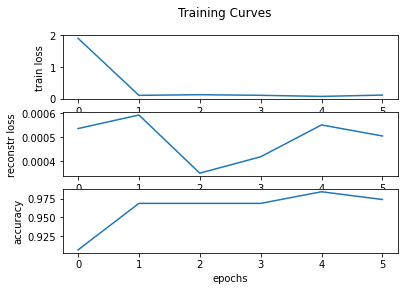

In [13]:
total_batches = 64*25
best_acc = 0
lamda = 8
batch_size = 64
learning_rate = 0.01 

optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,betas=(0.9, 0.98),eps=1e-9)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',factor=0.99,patience=100)

loss_all_list = []
rcloss_all_list = []
accuracy_list = []

for batch in range(total_batches):
    
    intro, introtarget, whatmyname, yournameis = teacher.get_batch(batch_size)
    
    out_vecs, trg_end, rcl, rcli = model.teacher_forcing(intro, introtarget)
    
    vocab_logits = model.vocab.emb2vocab(out_vecs)
    
    predictions = vocab_logits.view(-1, vocab_logits.size(-1))
    
    target = trg_end.view(-1)

    batch_loss = F.cross_entropy(predictions, target, 
                                 ignore_index = model.vocab.word2index["<PAD>"])

    reconstruction_loss = lamda*rcl
    
    ################# Next Part of Conversation ########################
    
    out_vecs, trg_end, rcl, rcli = model.teacher_forcing(whatmyname, yournameis)
    
    vocab_logits = model.vocab.emb2vocab(out_vecs)

    predictions = vocab_logits.view(-1, vocab_logits.size(-1))
    
    target = trg_end.view(-1)
    
    acc = accuracy_score(target, torch.argmax(predictions, dim=1))

    batch_loss += F.cross_entropy(predictions, target, 
                                 ignore_index = model.vocab.word2index["<PAD>"])
    
    reconstruction_loss += lamda*rcl
    conversation_loss = batch_loss + reconstruction_loss
    
    scheduler.step(conversation_loss)
    optimizer.zero_grad()
    conversation_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    if batch % int(total_batches/20 + 1) == 0:
        
        loss_all_list.append(conversation_loss.float().item())
        rcloss_all_list.append(reconstruction_loss.float().item())
        accuracy_list.append(acc)
        mean_accuracy = np.mean(accuracy_list[-10:])

        if mean_accuracy > best_acc:
            print('Saving Model...')
            best_acc = mean_accuracy
            
            pickle.dump(model.vocab.word2index,open("modelstate/word2index.p","wb"))
            pickle.dump(model.vocab.index2word,open("modelstate/index2word.p","wb"))
            pickle.dump(model.vocab.emb2vocab.weight,open("modelstate/emb2vocab.weight.p","wb"))
            pickle.dump(model.vocab.embedding.weight,open("modelstate/embedding.weight.p","wb"))
            pickle.dump(model.context_vec,open("modelstate/context_vec.p","wb"))
            pickle.dump(model.mnm.memfunc.Ws,open("modelstate/Ws.p","wb"))
            save_model(model,"modelstate/task.pth")
            
        print("mean accuracy", round(mean_accuracy,4), 
              "celoss", round(batch_loss.float().item(),4), 
              "rcloss", round(reconstruction_loss.float().item(),6), 
              "d_rcloss", round((rcli - rcl).float().item(),4),
              "training progress", round(batch/total_batches,4),
              "learning rate", scheduler._last_lr)
            
        if mean_accuracy > 0.96:
            break

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.suptitle('Training Curves')
ax1.set(xlabel='epochs', ylabel='train loss')
ax2.set(xlabel='epochs', ylabel='reconstr loss')
ax3.set(xlabel='epochs', ylabel='accuracy')
ax1.plot(loss_all_list, label='train loss')
ax2.plot(rcloss_all_list, label='reconstrunction loss')
ax3.plot(accuracy_list, label='accuracy')

These are the names of all the trainable parameters, aka, weights in this model. there are a few other parameters that are not in the computational graph of pytorch, which is why there are other saved files to be saved and re-loaded besides `save_model(model,"modelstate/task.pth")` such as the embeddings, vocabulary dictionary, the vector that stores the last memory and the matrices that store the memories. 

In [18]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

vocab.embedding.weight
vocab.emb2vocab.weight
encodeInput.encodelayers.0.norm_1.alpha
encodeInput.encodelayers.0.norm_1.bias
encodeInput.encodelayers.0.attn.q_linear.weight
encodeInput.encodelayers.0.attn.q_linear.bias
encodeInput.encodelayers.0.attn.k_linear.weight
encodeInput.encodelayers.0.attn.k_linear.bias
encodeInput.encodelayers.0.attn.v_linear.weight
encodeInput.encodelayers.0.attn.v_linear.bias
encodeInput.encodelayers.0.attn.out.weight
encodeInput.encodelayers.0.attn.out.bias
encodeInput.encodelayers.0.norm_2.alpha
encodeInput.encodelayers.0.norm_2.bias
encodeInput.encodelayers.0.ff.linear_1.weight
encodeInput.encodelayers.0.ff.linear_1.bias
encodeInput.encodelayers.0.ff.linear_2.weight
encodeInput.encodelayers.0.ff.linear_2.bias
encodeInput.encodelayers.1.norm_1.alpha
encodeInput.encodelayers.1.norm_1.bias
encodeInput.encodelayers.1.attn.q_linear.weight
encodeInput.encodelayers.1.attn.q_linear.bias
encodeInput.encodelayers.1.attn.k_linear.weight
encodeInput.encodelayers.1.at

you can reload the notebook and reload just these saved parameters without training and the model should still exhibit the same memorization abilities

In [5]:
model.vocab.emb2vocab.weight = pickle.load(open("modelstate/emb2vocab.weight.p","rb"))
model.vocab.embedding.weight = pickle.load(open("modelstate/embedding.weight.p","rb"))
model.vocab.word2index = pickle.load(open("modelstate/word2index.p","rb"))
model.vocab.index2word = pickle.load(open("modelstate/index2word.p","rb"))
load_model(model,"modelstate/task.pth")
model.mnm.memfunc.Ws = pickle.load(open("modelstate/Ws.p","rb"))
model.context_vec = pickle.load(open("modelstate/context_vec.p","rb"))
model

Bot(
  (vocab): Vocab(
    (embedding): Embedding(4, 32)
    (emb2vocab): Linear(in_features=32, out_features=4, bias=False)
  )
  (encodeInput): Transformer(
    (pe): PositionalEncoder(
      (dropout): Dropout(p=0.05, inplace=False)
    )
    (encodelayers): ModuleList(
      (0): EncoderLayer(
        (norm_1): Norm()
        (dropout_1): Dropout(p=0.05, inplace=False)
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=32, out_features=32, bias=True)
          (k_linear): Linear(in_features=32, out_features=32, bias=True)
          (v_linear): Linear(in_features=32, out_features=32, bias=True)
          (dropout): Dropout(p=0.05, inplace=False)
          (out): Linear(in_features=32, out_features=32, bias=True)
        )
        (norm_2): Norm()
        (ff): FeedForward(
          (linear_1): Linear(in_features=32, out_features=2048, bias=True)
          (dropout): Dropout(p=0.05, inplace=False)
          (linear_2): Linear(in_features=2048, out_features=

In [6]:
for tell in [
             'my name is melissa', 'what is my name?', 
             'my name is vicki', 'what is my name?',
             'my name is zen', 'what is my name?',
             'my name is sky', 'what is my name?',
             ]:

    print(' > '+ tell)
    reply = model.string2string(tell)
    print(' > '+ reply)
    print(' ')

 > my name is melissa
 > hi melissa
 
 > what is my name?
 > its melissa
 
 > my name is vicki
 > hi vicki
 
 > what is my name?
 > its vicki
 
 > my name is zen
 > hi zen
 
 > what is my name?
 > its zen
 
 > my name is sky
 > hi sky
 
 > what is my name?
 > its sky
 
